<a href="https://colab.research.google.com/github/Masakinka/python_for_ds_task/blob/main/2_4_kNN_%D0%9A%D1%80%D0%BE%D1%81%D0%B2%D0%B0%D0%BB%D1%96%D0%B4%D0%B0%D1%86%D1%96%D1%8F_%D1%96_%D1%82%D1%8E%D0%BD%D0%B8%D0%BD%D0%B3_%D0%B3%D1%96%D0%BF%D0%B5%D1%80%D0%BF%D0%B0%D1%80%D0%B0%D0%BC%D0%B5%D1%82%D1%80%D1%96%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням kNearestNeighboors, знайдемо оптимальні гіперпараметри для цього методу і зробимо базові ансамблі. Це дасть змогу порівняти перформанс моделі з попередніми вивченими методами.

0. Зчитайте дані `train.csv` та зробіть препроцесинг використовуючи написаний Вами скрипт `process_bank_churn.py` так, аби в результаті отримати дані в розбитті X_train, train_targets, X_val, val_targets для експериментів.

  Якщо Вам не вдалось реалізувати в завданні `2.3. Дерева прийняття рішень` скрипт `process_bank_churn.py` - можна скористатись готовим скриптом з запропонованого рішення того завдання.

In [1]:
 # Підключення Google Drive
from google.colab import drive
drive.mount('/content/drive')

 # Додавання шляху до нотаток
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks')

# Завантаження розширення autoreload
%load_ext autoreload
%autoreload 2

Mounted at /content/drive


In [2]:
!pip install opendatasets --upgrade --quiet

In [3]:
# Імпорт необхідних функцій
import opendatasets as od
import pandas as pd
from process_bank_churn import preprocess_data, preprocess_new_data, main_process_data

In [4]:
# Налаштування відображення даних
pd.set_option('display.max.rows',130)
pd.set_option('display.max.columns',130)
pd.set_option('float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

In [5]:
# Завантаження даних з Kaggle
dataset_url = 'https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu/'
od.download(dataset_url)
data_dir = './bank-customer-churn-prediction-dlu'
raw_df = pd.read_csv('./bank-customer-churn-prediction-dlu/train.csv')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: viktoriiabortnikova
Your Kaggle Key: ··········


100%|██████████| 637k/637k [00:00<00:00, 59.6MB/s]


Extracting archive ./bank-customer-churn-prediction-dlu/bank-customer-churn-prediction-dlu.zip to ./bank-customer-churn-prediction-dlu


In [6]:
# Визначення колонок для виключення
excluded_cols = ['CustomerId', 'CreditScore', 'Tenure', 'HasCrCard', 'EstimatedSalary', 'Surname', 'id']
# Попередня обробка даних
datasets = preprocess_data(raw_df, excluded_cols)

In [7]:
# Виведення інформації про датасет
print("train_X shape:", datasets['train_X'].shape)
print("train_y shape:", datasets['train_y'].shape)
print("val_X shape:", datasets['val_X'].shape)
print("val_y shape:", datasets['val_y'].shape)
print("Input columns:", datasets['input_cols'])
print("Scaler:", datasets['scaler'])
print("Encoder:", datasets['encoder'])

# Перевірка оброблених даних
print(datasets['train_X'].head())

train_X shape: (12000, 9)
train_y shape: (12000,)
val_X shape: (3000, 9)
val_y shape: (3000,)
Input columns: ['Age', 'Balance', 'NumOfProducts', 'IsActiveMember', 'Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male']
Scaler: StandardScaler()
Encoder: OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    Age  Balance  NumOfProducts  IsActiveMember  Geography_France  Geography_Germany  Geography_Spain  Gender_Female  Gender_Male
0 -0.94     1.48          -1.11            1.02              1.00               0.00             0.00           0.00         1.00
1  0.16     2.25          -1.11           -0.98              1.00               0.00             0.00           1.00         0.00
2 -0.33     1.22           0.77           -0.98              0.00               1.00             0.00           0.00         1.00
3  2.50    -0.72           0.77            1.02              0.00               0.00             1.00           0.00         1.00
4

1. Навчіть на цих даних класифікатор kNN з параметрами за замовченням і виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах. Зробіть заключення про отриману модель: вона хороша/погана, чи є high bias/high variance?

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

In [9]:
# Витягування навчальних та валідаційних вибірок
X_train = datasets['train_X']
y_train = datasets['train_y']
X_val = datasets['val_X']
y_val = datasets['val_y']

# Навчання класифікатора kNN
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Прогнозування ймовірностей
y_train_pred_proba = knn.predict_proba(X_train)[:, 1]
y_val_pred_proba = knn.predict_proba(X_val)[:, 1]

# Обчислення значень ROC AUC
roc_auc_train = roc_auc_score(y_train, y_train_pred_proba)
roc_auc_val = roc_auc_score(y_val, y_val_pred_proba)

# Виведення AUROC
print(f"AUROC для тренувальної вибірки: {roc_auc_train}")
print(f"AUROC для валідаційної вибірки: {roc_auc_val}")

AUROC для тренувальної вибірки: 0.9470605471076281
AUROC для валідаційної вибірки: 0.8906228136360519


**Висновки**: Значення AUROC для тренувальної вибірки (0.947) значно вище, ніж для валідаційної вибірки (0.891), що вказує на певне перенавчання моделі. Отже, можна зробити висновок, що модель має high variance (високу дисперсію), що вказує на перенавчання (overfitting). Модель занадто добре підходить під тренувальні дані, але не здатна так само добре працювати на валідаційних даних.

2. Використовуючи `GridSearchCV` знайдіть оптимальне значення параметра `n_neighbors` для класифікатора `kNN`. Псотавте крос валідацію на 5 фолдів.

  Після успішного завершення пошуку оптимального гіперпараметра
    - виведіть найкраще значення параметра
    - збережіть в окрему змінну `knn_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `knn_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пукнтом (2) цього завдання? Чи є вона краще за дерево прийняття рішень з попереднього ДЗ?

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

In [11]:
# Визначення параметрів для пошуку по сітці
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15]
}

# Використання GridSearchCV для пошуку оптимальних параметрів
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Виведення найкращих параметрів
best_params = grid_search.best_params_
print(f"Найкращі параметри: {best_params}")

Найкращі параметри: {'n_neighbors': 15}


In [12]:
# Збереження найкращої моделі
knn_best = grid_search.best_estimator_

# Оцінка якості передбачень на тренувальній та валідаційній вибірках
y_train_pred_proba = knn_best.predict_proba(X_train)[:, 1]
y_val_pred_proba = knn_best.predict_proba(X_val)[:, 1]

roc_auc_train_best = roc_auc_score(y_train, y_train_pred_proba)
roc_auc_val_best = roc_auc_score(y_val, y_val_pred_proba)

print(f"AUROC для тренувальної вибірки (оптимальні параметри): {roc_auc_train_best}")
print(f"AUROC для валідаційної вибірки (оптимальні параметри): {roc_auc_val_best}")

AUROC для тренувальної вибірки (оптимальні параметри): 0.9469101656013145
AUROC для валідаційної вибірки (оптимальні параметри): 0.9199406680842308


In [13]:
# Висновок про якість моделі
if roc_auc_val_best > roc_auc_val:
    print("Якість моделі покращилася порівняно з попередньою.")
else:
    print("Якість моделі не покращилася порівняно з попередньою.")

Якість моделі покращилася порівняно з попередньою.


Для дерева прийняття рішень перформас був такий:
- AUROC для тренувальної вибірки: 0.936205080272877
- AUROC для валідаційної вибірки: 0.9167833870635844

**Висновки**:
1. Оптимізація гіперпараметра n_neighbors за допомогою GridSearchCV покращила якість моделі kNN.
- AUROC для тренувальної вибірки: 0.9469 (з оптимальними параметрами).
- AUROC для валідаційної вибірки: 0.9199 (з оптимальними параметрами).
2. Якість моделі покращилася порівняно з попередньою версією kNN (параметри за замовченням), де AUROC для валідаційної вибірки був 0.8906.
3. Порівняно з деревом прийняття рішень, модель kNN з оптимальними параметрами показала дещо кращі результати на валідаційній вибірці (0.9199 проти 0.9167).


3. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `GridSearchCV` за сіткою параметрів
  - `max_depth` від 1 до 20 з кроком 2
  - `max_leaf_nodes` від 2 до 10 з кроком 1

  Обовʼязково при цьому ініціюйте модель з фіксацією `random_seed`.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `dt_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли вручну?

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import time

In [15]:
# Параметри для сіткового пошуку
param_grid = {
    'max_depth': range(1, 21, 2),
    'max_leaf_nodes': range(2, 11, 1)
}

In [16]:
# Ініціалізація моделі з фіксованим random_state
dt = DecisionTreeClassifier(random_state=42)

# Ініціалізація GridSearchCV
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=3, scoring='roc_auc')

# Вимірювання часу пошуку оптимальних гіперпараметрів
start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()

# Виведення найкращих параметрів
best_params = grid_search.best_params_
print(f"Найкращі значення параметрів: {best_params}")

Найкращі значення параметрів: {'max_depth': 5, 'max_leaf_nodes': 10}


In [17]:
# Збереження найкращої моделі
dt_best = grid_search.best_estimator_

# Оцінка якості передбачень на тренувальній та валідаційній вибірці
roc_auc_train_best = roc_auc_score(y_train, dt_best.predict_proba(X_train)[:, 1])
roc_auc_val_best = roc_auc_score(y_val, dt_best.predict_proba(X_val)[:, 1])
print(f"AUROC для тренувальної вибірки (оптимальні параметри): {roc_auc_train_best}")
print(f"AUROC для валідаційної вибірки (оптимальні параметри): {roc_auc_val_best}")

# Виведення часу, необхідного для пошуку оптимальних гіперпараметрів
print(f"Час, необхідний для пошуку оптимальних гіперпараметрів: {end_time - start_time} секунд")

AUROC для тренувальної вибірки (оптимальні параметри): 0.9014754782174744
AUROC для валідаційної вибірки (оптимальні параметри): 0.9002184649152891
Час, необхідний для пошуку оптимальних гіперпараметрів: 5.263485670089722 секунд


**Висновки:**
Модель з ручним пошуком параметрів для DecisionTreeClassifier показала кращу продуктивність як на тренувальній, так і на валідаційній вибірках порівняно з моделлю, знайденою за допомогою GridSearchCV. Отже, ручний пошук параметрів дав кращі результати у цьому конкретному випадку.

4. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `RandomizedSearchCV` за заданою сіткою параметрів і кількість ітерацій 40.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, зафіксуйте `random_seed` процедури крос валідації та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_random_search_best` найкращу модель, знайдену з `RandomizedSearchCV`
    - оцініть якість передбачень  `dt_random_search_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли з `GridSearch`?
    - проаналізуйте параметри `dt_random_search_best` і порівняйте з параметрами `dt_best` - яку бачите відмінність? Ця вправа потрібна аби зрозуміти, як різні налаштування `DecisionTreeClassifier` впливають на якість моделі.

In [20]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

In [21]:
params_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1, 20),
    'max_leaf_nodes': np.arange(2, 20),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}

In [22]:
# Ініціалізація моделі
dt = DecisionTreeClassifier(random_state=42)

# Ініціалізація RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=dt,
    param_distributions=params_dt,
    n_iter=40,
    scoring='roc_auc',
    cv=3,
    random_state=42
)

# Початок пошуку
start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()

# Найкращі параметри
best_params = random_search.best_params_
print(f"Найкращі значення параметрів: {best_params}")

Найкращі значення параметрів: {'splitter': 'best', 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_leaf_nodes': 14, 'max_features': None, 'max_depth': 16, 'criterion': 'entropy'}


In [23]:
# Збереження найкращої моделі
dt_random_search_best = random_search.best_estimator_

# Оцінка якості передбачень на тренувальній та валідаційній вибірці
roc_auc_train_best = roc_auc_score(y_train, dt_random_search_best.predict_proba(X_train)[:, 1])
roc_auc_val_best = roc_auc_score(y_val, dt_random_search_best.predict_proba(X_val)[:, 1])

print(f"AUROC для тренувальної вибірки (оптимальні параметри): {roc_auc_train_best}")
print(f"AUROC для валідаційної вибірки (оптимальні параметри): {roc_auc_val_best}")

# Виведення часу, необхідного для пошуку оптимальних гіперпараметрів
print(f"Час, необхідний для пошуку оптимальних гіперпараметрів: {end_time - start_time} секунд")

AUROC для тренувальної вибірки (оптимальні параметри): 0.9169275635848141
AUROC для валідаційної вибірки (оптимальні параметри): 0.9166204815145071
Час, необхідний для пошуку оптимальних гіперпараметрів: 1.406728982925415 секунд


Аналіз по параметрам:
1.  RandomizedSearchCV має максимальну глибину 16, що вказує на те, що глибше дерево може краще навчитися на даних. Для GridSearchCV максимальна глибина була лише 5.
2. RandomizedSearchCV має max_leaf_nodes = 14, що більше ніж 10, знайдене GridSearchCV, що також свідчить про складнішу структуру дерева.
3. RandomizedSearchCV має 'entropy', тоді як GridSearchCV обрала 'gini'. Це вказує на те, що 'entropy' може бути більш підходящим критерієм для цих даних.
4. RandomizedSearchCV також використання інших параметри, такі як min_samples_split і min_samples_leaf, дозволило точніше налаштувати модель для досягнення кращих результатів.

Висновки: Модель, знайдена за допомогою RandomizedSearchCV, показала кращі результати AUROC як для тренувальної, так і для валідаційної вибірок у порівнянні з моделлю, знайденою за допомогою GridSearchCV. Це свідчить про те, що RandomizedSearchCV з використанням більшої кількості параметрів та більш широким діапазоном значень допомогла знайти більш оптимальні налаштування для дерева прийняття рішень.

Тако ж порівнявши з моделю, ручного налаштування можно зробити висновок, шо модель, знайдена за допомогою RandomizedSearchCV, має трохи нижчий AUROC для тренувальної вибірки та незначно нижчий AUROC для валідаційної вибірки у порівнянні з ручним пошуком гіперпараметрів. Це свідчить про те, що обидва підходи знайшли досить хороші налаштування, але модель, знайдена вручну, показала трохи кращий результат.



5. Якщо у Вас вийшла метрика `AUROC` в цій серії експериментів - зробіть ще один `submission` на Kaggle і додайте код для цього і скріншот скора на публічному лідерборді нижче.

  Сподіваюсь на цьому етапі ви вже відчули себе справжнім дослідником 😉

In [24]:
test_df = pd.read_csv('./bank-customer-churn-prediction-dlu/test.csv')
test_df.head(5)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15000,15594796.00,Chu,584.00,Germany,Male,30.00,2.00,146053.66,1.00,1.00,1.00,157891.86
1,15001,15642821.00,Mazzi,551.00,France,Male,39.00,5.00,0.00,2.00,1.00,1.00,67431.28
2,15002,15716284.00,Onyekachi,706.00,France,Male,43.00,8.00,0.00,2.00,1.00,0.00,156768.45
3,15003,15785078.00,Martin,717.00,Spain,Male,45.00,3.00,0.00,1.00,1.00,1.00,166909.87
4,15004,15662955.00,Kenechukwu,592.00,Spain,Male,43.00,8.00,0.00,2.00,1.00,1.00,143681.97


In [25]:
# Визначення змінних
input_cols = datasets['input_cols']
scaler = datasets['scaler']
encoder = datasets['encoder']

# Попередня обробка тестових даних
X_test = preprocess_new_data(test_df, input_cols, scaler, encoder, excluded_cols)

# Ручний пошук гіперпараметрів
best_clf_manual = DecisionTreeClassifier(random_state=42, max_depth=7)
best_clf_manual.fit(datasets['train_X'], datasets['train_y'])

# Прогнозування ймовірностей для тренувальних та валідаційних вибірок
y_train_pred_proba_manual = best_clf_manual.predict_proba(datasets['train_X'])[:, 1]
y_val_pred_proba_manual = best_clf_manual.predict_proba(datasets['val_X'])[:, 1]

# Обчислення AUROC для тренувальних та валідаційних вибірок
roc_auc_train_manual = roc_auc_score(datasets['train_y'], y_train_pred_proba_manual)
roc_auc_val_manual = roc_auc_score(datasets['val_y'], y_val_pred_proba_manual)

# Прогнозування для тестових даних
predictions_manual = best_clf_manual.predict(X_test)
predictions_proba_manual = best_clf_manual.predict_proba(X_test)[:, 1]

# Виведення AUROC для ручного пошуку гіперпараметрів
print(f"AUROC для тренувальної вибірки (ручний пошук): {roc_auc_train_manual}")
print(f"AUROC для валідаційної вибірки (ручний пошук): {roc_auc_val_manual}")

AUROC для тренувальної вибірки (ручний пошук): 0.9393145713767181
AUROC для валідаційної вибірки (ручний пошук): 0.9238754372727898


In [26]:
# Модель з RandomizedSearchCV
best_clf_random = dt_random_search_best
best_clf_random.fit(datasets['train_X'], datasets['train_y'])

# Прогнозування ймовірностей для тренувальних та валідаційних вибірок
y_train_pred_proba_random = best_clf_random.predict_proba(datasets['train_X'])[:, 1]
y_val_pred_proba_random = best_clf_random.predict_proba(datasets['val_X'])[:, 1]

# Обчислення AUROC для тренувальних та валідаційних вибірок
roc_auc_train_random = roc_auc_score(datasets['train_y'], y_train_pred_proba_random)
roc_auc_val_random = roc_auc_score(datasets['val_y'], y_val_pred_proba_random)

# Прогнозування для тестових даних
predictions_random = best_clf_random.predict(X_test)
predictions_proba_random = best_clf_random.predict_proba(X_test)[:, 1]

# Виведення AUROC для RandomizedSearchCV
print(f"AUROC для тренувальної вибірки (RandomizedSearchCV): {roc_auc_train_random}")
print(f"AUROC для валідаційної вибірки (RandomizedSearchCV): {roc_auc_val_random}")

AUROC для тренувальної вибірки (RandomizedSearchCV): 0.9169275635848141
AUROC для валідаційної вибірки (RandomizedSearchCV): 0.9166204815145071


Модель з ручним пошуком гіперпараметрів має вищі значення AUROC як для тренувальної, так і для валідаційної вибірки. Це свідчить про те, що вона краще узгоджується з даними і, можливо, краще узагальнює на нових даних у порівнянні з моделлю з RandomizedSearchCV.

Однак модель з RandomizedSearchCV також показала добрий результат, і різниця у значеннях AUROC не дуже велика.

Тому зроблю самбміщен для обох моделей.

In [27]:
# Збереження результатів для обох моделей
submission_df_manual = pd.read_csv('./bank-customer-churn-prediction-dlu/sample_submission.csv')
submission_df_manual['Exited'] = predictions_proba_manual
submission_df_manual.to_csv('drive/MyDrive/Colab Notebooks/data/submission_manual.csv', index=False)

submission_df_random = pd.read_csv('./bank-customer-churn-prediction-dlu/sample_submission.csv')
submission_df_random['Exited'] = predictions_proba_random
submission_df_random.to_csv('drive/MyDrive/Colab Notebooks/data/submission_random.csv', index=False)


In [28]:
submission_df_manual.head()

,id,Exited
0,15000,0.17
1,15001,0.02
2,15002,0.06
3,15003,0.71
4,15004,0.04


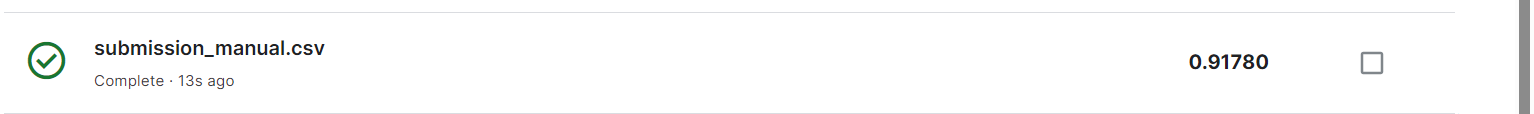

In [29]:
submission_df_random.head()

,id,Exited
0,15000,0.24
1,15001,0.01
2,15002,0.20
3,15003,0.57
4,15004,0.08


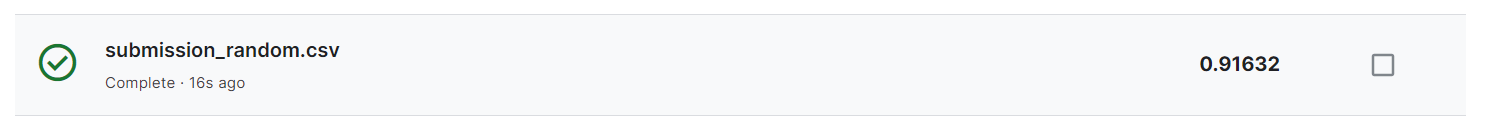

**Висновки:** Ручний пошук гіперпараметрів показав кращі результати на валідаційній вибірці і трохи кращий публічний скор на Kaggle в порівнянні з RandomizedSearchCV.RandomizedSearchCV також дав добрі результати, але трохи гірші в порівнянні з ручним пошуком. Це може бути пов'язано з тим, що в ручному пошуку гіперпараметри були більш адаптовані до конкретної вибірки даних. RandomizedSearchCV знайшов інші параметри, які також дали добрі результати, але не такі високі як в ручному пошуку.
Це означає, що ручний пошук може бути ефективним для пошуку гіперпараметрів, але RandomizedSearchCV є більш автоматизованим підходом, який дозволяє знайти добрі параметри за менший час без великого ручного втручання.